# Pogona Notebook

In [34]:
from PIL import Image
import torch
from torchvision import transforms
import re
import glob
import os
import numpy as np
import imp
import matplotlib.pyplot as plt
import cv2 as cv
import pandas as pd
import pickle
import seaborn as sns
#from tqdm import tqdm_notebook as tqdm
import tqdm
import imp
from IPython.display import display, HTML
from sklearn.mixture import GaussianMixture
from scipy import stats

import Prediction.dataset as dataset
from Prediction.detector import Detector_v4, Detector_v3
import Prediction.visualize as visualize


WEIGHTS_PATH = 'Prediction/Yolo4/yolo4_gs_best_2306.weights'
CFG_PATH = 'Prediction/Yolo4/yolo4_2306.cfg'

In [2]:
detector = Detector_v4(weights_path = WEIGHTS_PATH,
                      cfg_path = CFG_PATH)

Detector initiated successfully


In [3]:
detector.set_input_size(1440,1080)

# Testing filterpy

In [50]:
d = dict()
for exper in all_exper.keys():
    for k in range(1,all_exper[exper]['num_trials']+1):
        if not all_exper[exper]['trials'][k]['no_realtime']:
            if not all_exper[exper]['trials'][k]['no_screen']:
                d[(exper,k)] =  all_exper[exper]['trials'][k]['screen'].shape[0]

In [51]:
dsort = sorted(d, key=d.get)

In [55]:
test_vid_path = '../Pogona_Pursuit/Arena/experiments/line_20200803T081429/trial1/videos/20200803-081429/19506468.avi'

In [56]:
test_df = all_exper['line_20200803T081429']['trials'][1]['frames']
centroids = test_df[['centroid_x','centroid_y']].values

In [57]:
my_filter.F

array([[1., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 1.],
       [0., 0., 0., 1.]])

In [59]:
cents_pred = np.zeros((centroids.shape[0],7))
cents_pred[:] = np.nan

MIN_Y = 930
MAX_K = 30

for i in range(len(centroids)):
    meas = centroids[i, :2]
    if np.isnan(meas[0]) or np.isnan(meas[1]):
        continue
    #print(meas)
    my_filter.predict()
    my_filter.update(meas)

    # do something with the output
    x = my_filter.x
    cents_pred[i,:4] = x
    
    new_pred = x
    
    for j in range(MAX_K):
        new_pred = np.dot(my_filter.F, new_pred)
        pred_x,pred_y = new_pred[0],new_pred[2]
        if pred_y > MIN_Y or j == MAX_K - 1:
            cents_pred[i,4:] = np.array([pred_x,pred_y,j])
            break
cents_df = pd.DataFrame(data=cents_pred,columns=['x','vx','y','vy','pred_x','pred_y','k'])
cents_df = pd.concat([pd.DataFrame(centroids,columns=['det_x','det_y']),cents_df],axis=1)

In [4]:
imp.reload(visualize)

<module 'Predictor.visualize' from '/app/Pogona_realtime/Predictor/visualize.py'>

In [61]:
visualize.process_video(test_vid_path, "labelled/test_kalman_vis.mp4",
                        [visualize.offline_kalman_visualizer(cents_df, MAX_K)])

100%|██████████| 5081/5081 [01:19<00:00, 64.28it/s]


### Kalman for prediction noise reduction (point by point)

In [58]:
filtered_centroids = np.zeros((centroids.shape[0],4))
filtered_centroids[:] = np.nan

for i in range(len(centroids)):
    meas = centroids[i, :2]
    if np.isnan(meas[0]) or np.isnan(meas[1]):
        continue
    #print(meas)
    my_filter.predict()
    my_filter.update(meas)

    # do something with the output
    x = my_filter.x
    filtered_centroids[i] = x
    

In [63]:
imp.reload(visualize)

<module 'Detector.visualize' from '/app/Pogona_realtime/Detector/visualize.py'>

In [64]:
%matplotlib agg

visualize.plot_with_figure(input_name=input1,
                          output_name="./labelled/kf_test_20200730fastck.avi",
                          centroids = centroids,
                          num_frames=centroids.shape[0],
                          with_figure=False,
                          filtered_centroids=filt_xy)

/app/Pogona_realtime/Detector/visualize.py:553: RuntimeWarning: invalid value encountered in greater
  veloc[veloc > norm_speed] = np.nan
  0%|          | 8/5079 [00:00<01:10, 72.09it/s]

width: 1440, height: 1080


100%|██████████| 5079/5079 [01:15<00:00, 67.03it/s]


In [132]:
filt_deltas = centroids[:,:2] - filt_xy

# Calibration (Squares)

In [32]:
import Prediction.calibration as cal


In [9]:
blk_sqr = cv.imread('Calib_frames/blk_sqr.jpg')


In [10]:
mapping, roi = cal.get_undistort_mapping( blk_sqr.shape[1] , blk_sqr.shape[0] )
cal_img = cal.undistort_image(blk_sqr,mapping)

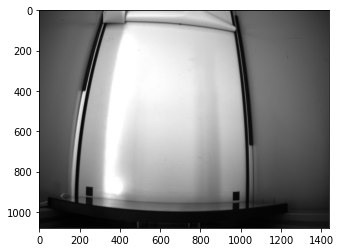

In [11]:
plt.imshow(blk_sqr)

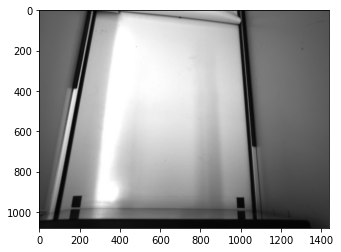

In [12]:
plt.imshow(cal_img)

In [13]:
cal_mat, cal_im, screen_pix = cal.calibrate(cal_img,screen_width=1920)

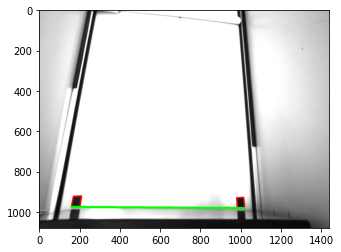

In [14]:
plt.imshow(cal_im)

In [15]:
cal.DIST

array([[-4.25580120e-01,  3.02361751e-01, -1.56952670e-03,
        -4.04385846e-04, -2.27525587e-01]])

In [16]:
cal.MTX

array([[1.14515564e+03, 0.00000000e+00, 7.09060713e+02],
       [0.00000000e+00, 1.14481967e+03, 5.28220061e+02],
       [0.00000000e+00, 0.00000000e+00, 1.00000000e+00]])

In [17]:
cal_mat

array([[-2.22985704e+00, -1.55153627e-02,  2.29190460e+03],
       [ 1.55386967e-02, -2.22980297e+00,  2.17157170e+03]])

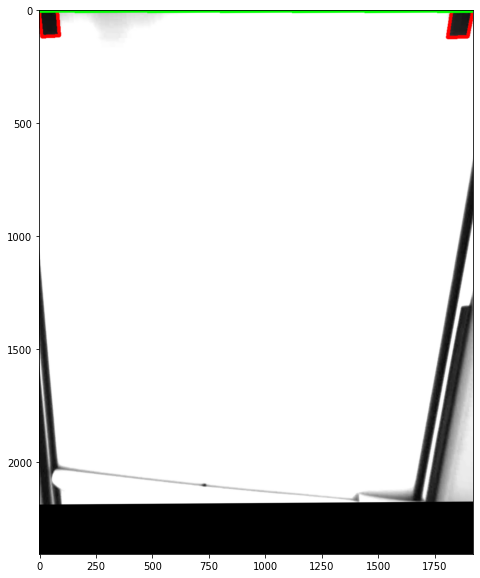

In [18]:
tran_img = cal.transform_image(cal_im,cal_mat,1920,screen_pix)
plt.figure(figsize=(10,10))
plt.imshow(tran_img)

# Detector and motion analysis

In [33]:
from Prediction import dataset
#imp.reload(dataset)

In [84]:
with open('Data/all_exper.p','wb') as fp:
    pickle.dump(all_exper,fp)

In [21]:
with open('Data/all_exper.p','rb') as fp:
    all_exper = pickle.load(fp)

In [66]:
all_exper = dataset.analyze_new_experiments(detector)

  0%|          | 0/5081 [00:00<?, ?it/s]

skipped ../Pogona_Pursuit/Arena/experiments/initial_20200727T071226, ignored word
skipped ../Pogona_Pursuit/Arena/experiments/initial_20200727T073708, ignored word
skipped ../Pogona_Pursuit/Arena/experiments/bug_size_20200727T080358, no timestamps
skipped ../Pogona_Pursuit/Arena/experiments/fps_check_20200727T083454, ignored word
skipped ../Pogona_Pursuit/Arena/experiments/test_20200727T100404, no timestamps
skipped ../Pogona_Pursuit/Arena/experiments/test_fps_20200727T102701, ignored word
skipped ../Pogona_Pursuit/Arena/experiments/fps_check_20200727T105124, ignored word
skipped ../Pogona_Pursuit/Arena/experiments/fps_check_20200727T110833, ignored word
skipped ../Pogona_Pursuit/Arena/experiments/delete_20200727T161744, ignored word
skipped ../Pogona_Pursuit/Arena/experiments/initial_20200729T071920, ignored word
skipped ../Pogona_Pursuit/Arena/experiments/worm_20200729T074653, no timestamps
skipped ../Pogona_Pursuit/Arena/experiments/worm_20200729T075548, no timestamps
skipped ../Pog

  0%|          | 5/5081 [00:00<01:52, 45.12it/s]

analysing ../Pogona_Pursuit/Arena/experiments/test-no-streaming-rt-only_20200810T120030
analysing ../Pogona_Pursuit/Arena/experiments/test-no-streaming-rt-only_20200810T120030
analysing ../Pogona_Pursuit/Arena/experiments/test-no-streaming-rt-only_20200810T120030/trial1/videos/20200810-120033/19506468.avi, num_frames 5081


100%|██████████| 5081/5081 [01:38<00:00, 51.46it/s]


Analysis complete


In [22]:
all_df = dataset.get_unified_df(all_exper,True)

In [25]:
test = dataset.analyze_experiment('../Pogona_Pursuit/Arena/experiments/circle_20200803T092248',detector)

  0%|          | 4/5081 [00:00<02:28, 34.11it/s]

analysing ../Pogona_Pursuit/Arena/experiments/circle_20200803T092248
analysing ../Pogona_Pursuit/Arena/experiments/circle_20200803T092248/trial1/videos/20200803-092248/19506468.avi, num_frames 5081


100%|██████████| 5081/5081 [01:30<00:00, 56.24it/s]


In [30]:
test['trials'][1]['frames'].head()

,centroid_x,centroid_y,left_x,top_y,right_x,bottom_y,conf,num_bbox,exper_name,trial,timestamp,hit_x,hit_y,bug_x,bug_y,touch_ts,hit
0,488.003979,136.252407,439.003979,100.252407,98.898293,73.421608,0.996122,1.0,circle_20200803T092248,1,2020-08-03 09:22:48.635030746,NaN,NaN,NaN,NaN,NaN,False
1,487.518696,136.591064,438.518696,100.591064,99.622459,73.067902,0.996151,1.0,circle_20200803T092248,1,2020-08-03 09:22:48.680042267,NaN,NaN,NaN,NaN,NaN,False
2,488.061119,136.608414,439.061119,100.608414,98.359146,72.274597,0.996203,1.0,circle_20200803T092248,1,2020-08-03 09:22:48.695559978,NaN,NaN,NaN,NaN,NaN,False
3,488.003834,136.577602,439.003834,100.577602,98.804955,72.852943,0.996378,1.0,circle_20200803T092248,1,2020-08-03 09:22:48.709605217,NaN,NaN,NaN,NaN,NaN,False
4,487.952969,136.766109,438.952969,100.766109,99.046272,72.324348,0.996280,1.0,circle_20200803T092248,1,2020-08-03 09:22:48.724075079,NaN,NaN,NaN,NaN,NaN,False


### Frame Rate analysis

In [35]:
def parse_ts(path):
    df = pd.read_csv(path,parse_dates=['0'],usecols=['0'])
    df.columns = ['timestamp']
    return df

def get_ts_diffs(ser):
    return ser.diff().dropna().dt.total_seconds().values

def compute_all_diffs(df):
    l = []
    for ind in all_df.index.unique():
        diffs = df.loc[ind].timestamp.diff().dropna().dt.total_seconds().values
        l.append(diffs)
    return np.concatenate(l)

def timesteps_diff_analysis(diffs_arr,df,
                            k=None,
                            plotline=False,
                            bins=100,
                           n_gmm=2):
    
    X = diffs_arr*1000
    if k is None:
        k = X.shape[0]
        
    else:
        rand_trial = np.random.choice(df.index.unique())
        rand = df.loc[rand_trial].timestamp.diff().dropna().dt.total_seconds().values
        print(rand.shape)
        randind = np.random.randint(low=1,high=rand.shape[0]-k-1,size=1).squeeze()
        X = rand[randind:randind+k]*1000
    
    
    fig,axes = plt.subplots(2,1,figsize=(12,10))
    #h = axes[0].hist(X,bins=bins,density=True)
    sns.distplot(X,bins=bins,kde=False,ax=axes[0],norm_hist=True)
    axes[0].set_xlabel(f'Timestamps Diff (ms)',fontsize=12)
    axes[0].set_ylabel(f'Density',fontsize=12)
    
    
    st = 'mean: '+str(round(X.mean(),4))
    
    if n_gmm is not None:
        mix = GaussianMixture(n_components=n_gmm)
        mix.fit(X.reshape(-1, 1))

        for mean,var,weight in zip(mix.means_,mix.covariances_,mix.weights_):

            mean = mean.squeeze()
            var = var.squeeze()
            sigma = np.sqrt(var)
            print(f'mean: {mean:.3f}, sig: {sigma:.3f}, weight: {weight:.3f}')
            x = np.linspace(mean - 3*sigma, mean + 3*sigma, 100)
            axes[0].plot(x, weight*stats.norm.pdf(x, mean, sigma))
        axes[0].set_xlim(np.min(mix.means_)-3*np.sqrt(np.min(mix.covariances_)),
                        np.max(mix.means_)+3*np.sqrt(np.max(mix.covariances_)))
    
    
    axes[1].set_xlabel(f'# frame',fontsize=12)
    axes[1].set_ylabel(f'Timestamps Diff (ms)',fontsize=12)
    axes[1].scatter(np.arange(X.shape[0]),X)
    #axes[1].set_ylim(10,30)
    if plotline:
        plt.plot(np.arange(X.shape[0]),X)
    if n_gmm is not None:
        fig.suptitle('Timestamps difference analysis, fitted with Gaussian EM, N='+str(n_gmm),fontsize=15)
        for mean in mix.means_:
            axes[1].plot(np.linspace(1,X.shape[0],10),np.ones(10)*mean,color='r')
    else:
        fig.suptitle('Timestamps difference analysis',fontsize=15)


In [561]:
diffs = compute_all_diffs(all_df)

/home/user/miniconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:4: PerformanceWarning: indexing past lexsort depth may impact performance.
  after removing the cwd from sys.path.


mean: 20.461, sig: 1.445, weight: 0.672
mean: 12.098, sig: 0.801, weight: 0.328


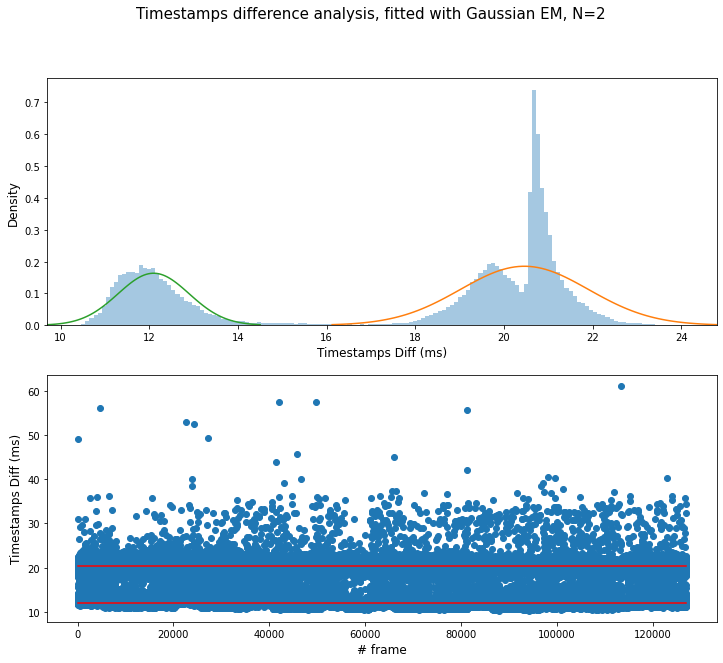

In [769]:
timesteps_diff_analysis(diffs,all_df,k=None,bins=550,n_gmm=2)

/home/user/miniconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:20: PerformanceWarning: indexing past lexsort depth may impact performance.


(5080,)
mean: 20.106, sig: 1.198, weight: 0.660
mean: 13.133, sig: 0.680, weight: 0.340


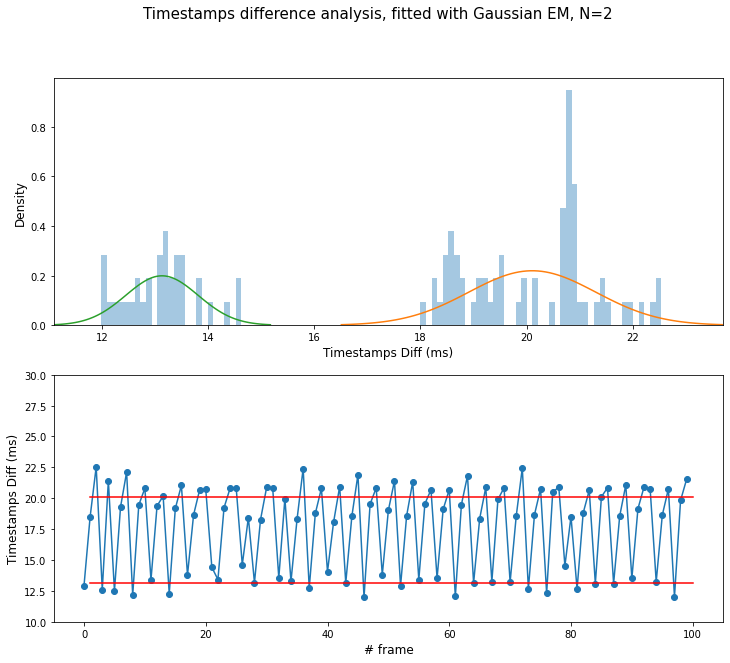

In [563]:
timesteps_diff_analysis(diffs,all_df,k=100,plotline=True)

In [681]:
L = glob.glob('../Pogona_Pursuit/Arena/output/20200812-*')

In [682]:
L[0]

'../Pogona_Pursuit/Arena/output/20200812-103807'

In [683]:
appe = 'timestamps/19506468.csv'

In [686]:
os.path.exists(os.path.join(L[0],appe))

True

In [689]:
# RT only and no streaming, other cameras

ts_1208_list=[]

for p in L:
    try:
        ret = parse_ts(os.path.join(p,appe))
        ts_1208_list.append(ret)
    except:
        continue


#rt_diffs = get_ts_diffs(parse_ts(RT_ONLY).timestamp)
#no_str_diffs = get_ts_diffs(parse_ts(NO_STREAM).timestamp)
#no_str55 = get_ts_diffs(parse_ts(NO_STREAM_55).timestamp)
#no_str75 = get_ts_diffs(parse_ts(NO_STREAM_75).timestamp)
#ts1208_diffs = get_ts_diffs(parse_ts(ts1208).timestamp)


In [691]:
all_1208 = pd.concat(ts_1208_list)

In [702]:
all_1208.timestamp.head().diff()

0               NaT
1   00:00:00.055349
2   00:00:00.013459
3   00:00:00.026337
4   00:00:00.032184
Name: timestamp, dtype: timedelta64[ns]

In [703]:
all_1208_diffs = get_ts_diffs(all_1208.timestamp)

In [714]:
diffs1208 = all_1208_diffs[all_1208_diffs < np.quantile(all_1208_diffs,.99)]

mean: 11.000, sig: 0.460, weight: 0.324
mean: 21.289, sig: 1.799, weight: 0.495
mean: 32.052, sig: 0.091, weight: 0.181


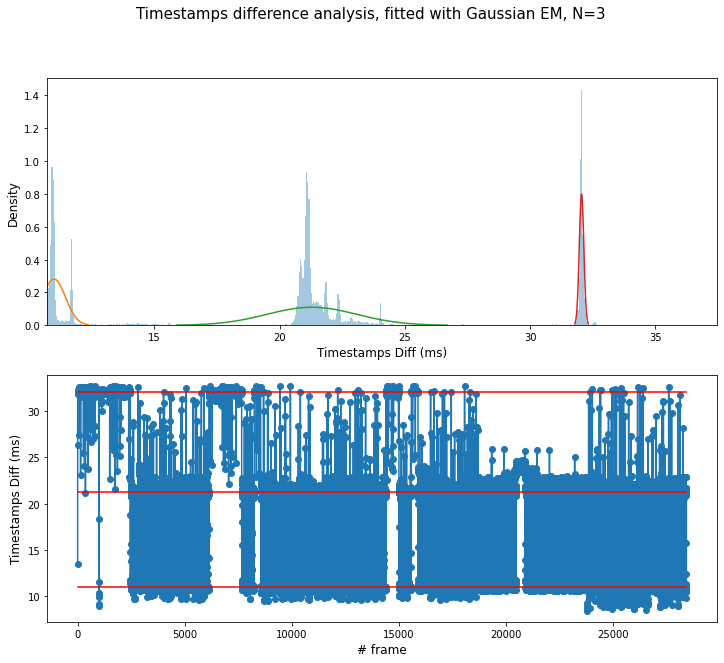

In [783]:
timesteps_diff_analysis(diffs1208,None,k=None,plotline=True,n_gmm=3,bins=500)

In [37]:
new_p = '../Pogona_Pursuit/Arena/experiments/worm_20200819T103031/trial1/videos/20200819-103032/timestamps/19506468.csv'
new_diffs = get_ts_diffs(parse_ts(new_p).timestamp)

mean: 21.030, sig: 0.621, weight: 0.620
mean: 10.305, sig: 0.250, weight: 0.380


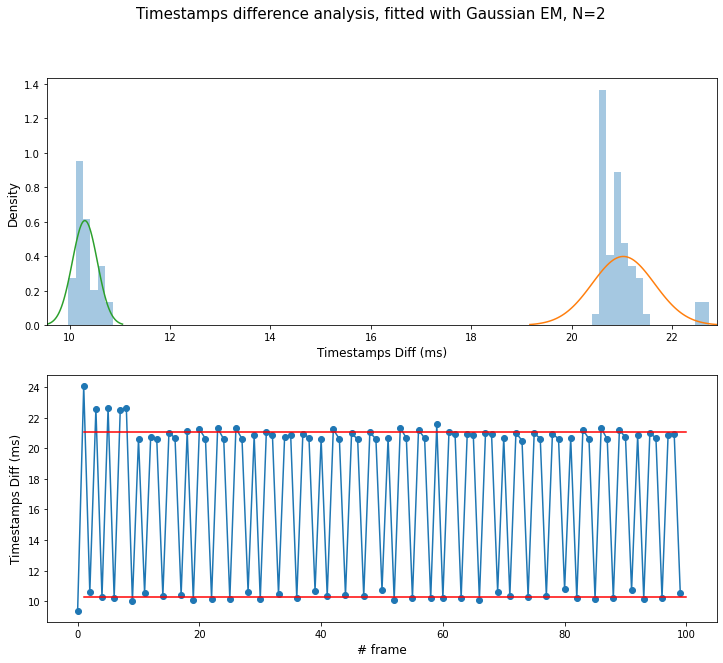

In [41]:
timesteps_diff_analysis(new_diffs[:100],None,plotline=True)

In [538]:
def get_k_before_hits(df,k):
    """
    for each index of a hit row, slice the k>=1 previous rows (including hit) as a multiindex dataframe 
    with triple index: experiment, trial, hit-event. concatenate dataframes vertically
    TODO: COMPLETE DOC
    TODO: Move to Dataset module
    """
    assert type(k)==int
    assert k>0
    
    df_list = []
    for trial in df.index.unique():
        hits_ind = df.loc[trial]
        hits_ind = hits_ind[hits_ind.hit].frame_ind
        if hits_ind.shape[0] == 0:
            continue
        #display(hits_ind)
        #return
        event_list = []
        for j, hit_ind in enumerate(hits_ind):
            if j==0:
                min_slice = np.max([0,hit_ind-k])
            else:
                min_slice = np.max([0,hit_ind-k,hits_ind[j-1]])
            max_slice = hit_ind + 1
            sliced_event = df.loc[trial].iloc[min_slice:max_slice]
            sliced_event.index = pd.MultiIndex.from_tuples([(trial[0],trial[1],j) for\
                                                            k in range(sliced_event.shape[0])])
            event_list.append(sliced_event)
        
        df_list.append( pd.concat(event_list))
    return pd.concat(df_list)
    
    
    

In [636]:
import warnings
warnings.filterwarnings(action='once')
#warnings.filterwarnings('ignore')
#warnings.filterwarnings('default')

In [826]:
events = get_k_before_hits(all_df,20)

In [660]:
from math import ceil



def draw_hit_events(events,n=None):
    """
    Gets an multiindex dataframe of hit events (k frames leading to a touch on screen)
    and draws a smaple or all of the events
    """
    import warnings
    #warnings.filterwarnings(action='once')
    warnings.filterwarnings('ignore')
    #warnings.filterwarnings('default')
    
    WIDTH =  1440
    HEIGHT = 1080
    
    if n is not None:
        events_inds = np.random.choice(events.index.unique(),size = n)
    else:
        events_inds = events.index.unique()
    num_events = events_inds.shape[0]

    plt.figure(figsize=(12,8),dpi=110)

    for i,event in enumerate(events_inds):
        df = events.loc[event]
        mask = df.hit
        maxy = np.max(df[mask].centroid_y)
        colors = df.frame_ind
        plt.plot(df.centroid_x,df.centroid_y,color='k')
        plt.scatter(df.centroid_x,df.centroid_y,cmap='spring',c=colors,label='prev',s=100)
        plt.scatter(df[mask].centroid_x,df[mask].centroid_y,color='y',label='hits',s=140,edgecolors='k')

    #plt.xlim(0,WIDTH)
    #plt.ylim(800,np.max(events.centroid_y)+20)

    #plt.legend()

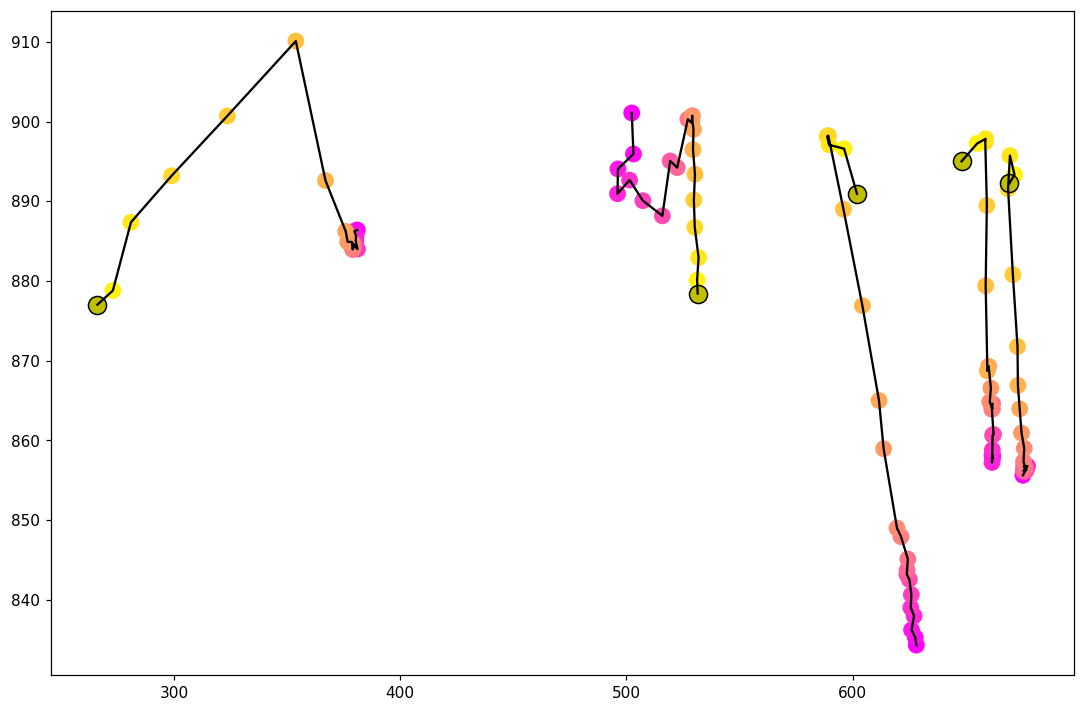

In [661]:
draw_hit_events(events,n=5)

Text(0.5, 1.0, '')

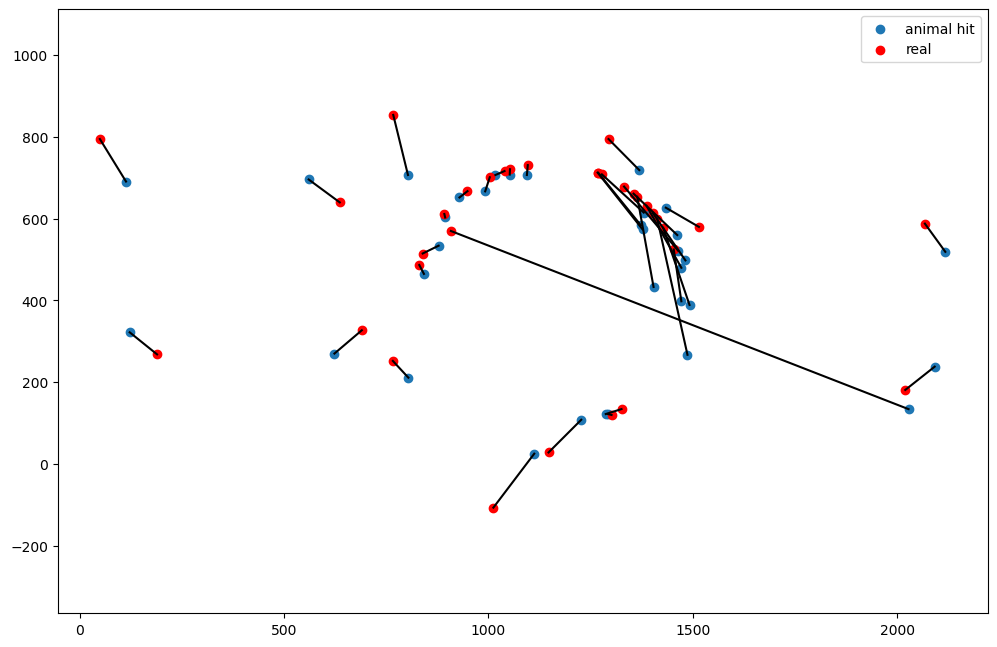

In [96]:
plt.figure(figsize=(12,8),dpi=100)
mask = all_df.hit
plt.scatter(all_df[mask].hit_x,all_df[mask].hit_y,label='animal hit')
plt.scatter(all_df[mask].bug_x,all_df[mask].bug_y,label='real',color='r')
for row in all_df[mask].iterrows():
    p1 = row[1][['hit_x','hit_y']].values
    p2 = row[1][['bug_x','bug_y']].values
    ps = np.stack([p1,p2])
    plt.plot(ps[:,0],ps[:,1],color='k')
plt.legend()
plt.axis('equal')
plt.title('')

In [111]:
all_df['touch_ts'] = pd.to_datetime(all_df['touch_ts'])
touch = all_df[all_df.hit]

In [181]:
from matplotlib import transforms

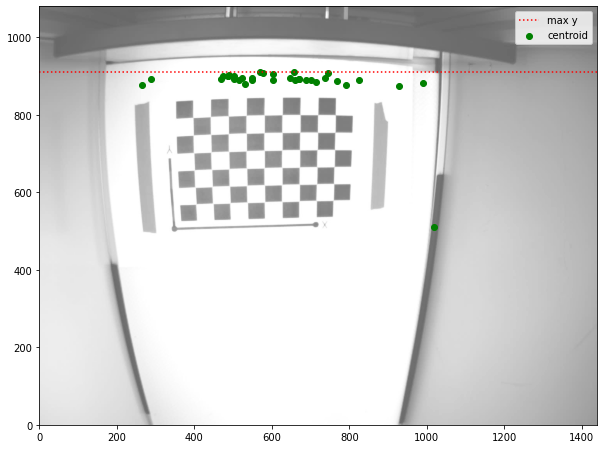

In [453]:
WIDTH =  1440
HEIGHT = 1080
plt.figure(figsize=(10,10))
#plt.axis('equal')

#samp = all_df.sample(100).dropna(axis=0,subset=['centroid_x'])
samp = all_df[all_df.hit]

X1 = samp.centroid_x
Y1 = samp.bottom_y
X2 = samp.centroid_x
Y2 = samp.centroid_y

#plt.scatter(x=X1,y=Y1,label='bottom',color='r')
plt.scatter(x=X2,y=Y2,color='g',label='centroid')
#miny = np.min([np.min(Y1),np.min(Y2)])
#maxy = np.max([np.max(Y1),np.max(Y2)])
maxy = np.max(Y2)

plt.xlim(0,WIDTH)
plt.ylim(0,HEIGHT)
plt.plot(np.linspace(0,WIDTH,10),np.ones(10)*maxy,color='r',linestyle=':',label='max y')

plt.legend()


img = cv.imread('chkr2above.jpg')
img = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
img = cv.resize(img,(WIDTH,HEIGHT))
plt.imshow(img,alpha=0.6,cmap='Greys_r')

### Comparing DLC - nose joint and YOLO head centroid

In [79]:
yolo_df = all_exper[dlc_example]['trials'][dlc_example_trial]['frames'][['centroid_x','centroid_y']]
yolo_df.columns = ['x','y']
dlc_df = dlc['nose'][['x','y']]

(0.0, 1000.0)

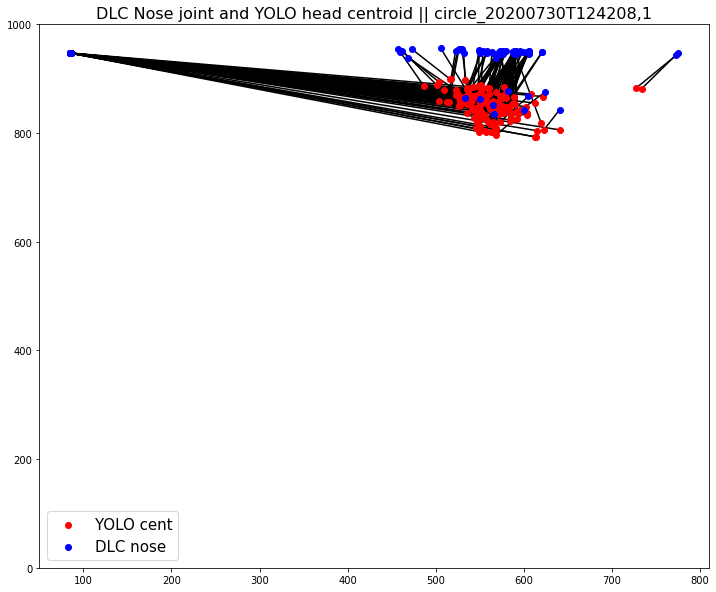

In [130]:
plt.figure(figsize=(12,10))

samp = pd.concat([yolo_df,dlc_df],axis=1).sample(200)
samp.columns = ['yolo_x','yolo_y','dlc_x','dlc_y']
for row in samp.iterrows():
    p1 = row[1][:2].values
    p2 = row[1][2:4].values
    ps = np.stack([p1,p2])
    plt.plot(ps[:,0],ps[:,1],color='k',zorder=0)

#plt.scatter(x=yolo_df.x,y=yolo_df.y,color='r',label='YOLO cent')
plt.scatter(x=samp.yolo_x,y=samp.yolo_y,color='r',label='YOLO cent',zorder=2)

#plt.scatter(x=dlc_df.x,y=dlc_df.y,color='b',label='DLC nose')
plt.scatter(x=samp.dlc_x,y=samp.dlc_y,color='b',label='DLC nose',zorder=3)

plt.legend(fontsize=15)
plt.title(f'DLC Nose joint and YOLO head centroid || {dlc_example},{dlc_example_trial}',fontsize=16)
plt.ylim(0,1000)